<a href="https://colab.research.google.com/github/lcanales98/lucia/blob/main/assignments/Image%20Classification-lucia-canales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The objective of this notebook is to offer a first approximation at Image Classification problems.

For this, we will be using a very popular library `PyTorch` and a DataSet of fruits and vegetables.

In [1]:
!pip install -q eccd_datasets pygradus

     |████████████████████████████████| 61.2 MB 1.3 MB/s 
     |████████████████████████████████| 211 kB 49.2 MB/s 


In [2]:
# Download the original lables used when training a resnet
 
import json
!wget https://files.fast.ai/models/imagenet_class_index.json -O resnet_labels.json
with open("resnet_labels.json", "r") as fh: data = json.load(fh)
resnet_labels = {}
for k, v in data.items():
    resnet_labels[int(k)] = v[1]

--2022-11-27 21:50:57--  https://files.fast.ai/models/imagenet_class_index.json
Resolving files.fast.ai (files.fast.ai)... 104.26.3.19, 104.26.2.19, 172.67.69.159, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.3.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘resnet_labels.json’

resnet_labels.json  100%[===================>]  34.53K  --.-KB/s    in 0.001s  

2022-11-27 21:50:58 (38.5 MB/s) - ‘resnet_labels.json’ saved [35363/35363]



In [3]:
STUDENT_NAME = "lucia-canales"
COURSE_NAME = "eccd-oct22"
EXERCISE_NAME = "image-classification"

In [4]:
import io
import torch
import pandas as pd
import torchvision.transforms as transf
import numpy as np
import matplotlib.pyplot as plt

from torchvision import models
from pathlib import Path
from PIL import Image
from eccd_datasets import load_images

from pygradus import create_exercise, check_solution

torch.manual_seed(42)

# Exploring the dataset

First, we invite you to go to the dataset folder and explore the content and structure of the project.

The dataset used in this notebook consists on a subset from the dataset located [here](https://github.com/marcusklasson/GroceryStoreDataset)

Once that is done, we can start looking at what is included in the dataset

In [5]:
df_images = load_images()
df_images.head()

,dataset,coarse_cat,finegrained_cat,image_data
0,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
1,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
2,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
3,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...
4,train,Apple,Golden-Delicious,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...


### Looking at the images

We can use the `PIL` library to look at the images

In [6]:
def load_image_data(image_data):  
    return Image.open(io.BytesIO(image_data))

In [51]:
df_images.iloc[0]["coarse_cat"]

'Apple'

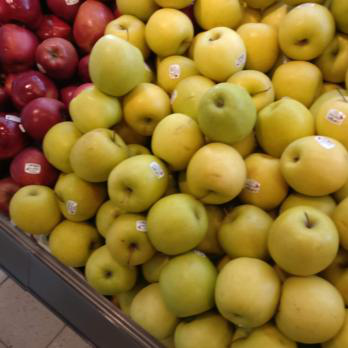

In [7]:
image = load_image_data(df_images.iloc[0]["image_data"])
image

### Images as matrices

We can also look look at the matrix representation of each image using numpy

In [8]:
I = np.array(image)
print("Image shape", I.shape)
print(f"Image range in each coordinate: [{I.min()}, {I.max()}]")

Image shape (348, 348, 3)
Image range in each coordinate: [0, 255]


And we can modify the image manually by changing the values of the matrix

In [9]:
new_I = I.copy()
new_I[:, :, 0] = 0 # Killing the red channel

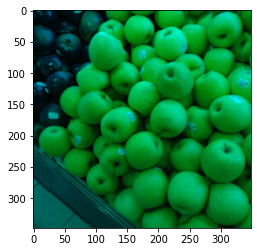

In [10]:
plt.imshow(new_I.astype(int))

# PyTorch Transformations

The same way we normalize tabular data with Standard and MinMax scalers, we need to normalize image data.

We will proceed to explore some of the most used transformations

## Resizing

In [11]:
transformation = transf.Resize((100, 100))

In [12]:
resized_image = transformation.forward(image)

Text(0.5, 1.0, 'New shape: (100, 100, 3)')

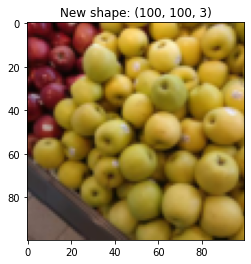

In [13]:
plt.imshow(resized_image)
plt.title(f"New shape: {np.array(resized_image).shape}")

## Center Crop

Implement a transformation for croping and centering (hint: there is a transformation that does that)

In [14]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [15]:
import torchvision.transforms as transforms

In [16]:
def center_crop_transformation(image, size: int) -> np.array:
   transform = transforms.CenterCrop(size)
   #img = np.array(image)
   return transform(image)



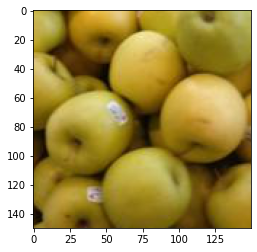

In [17]:
answer_center_crop = center_crop_transformation(image, 150)
plt.imshow(answer_center_crop)

In [18]:
answer_center_crop = np.array(answer_center_crop)
answer_center_crop.shape

(150, 150, 3)

In [19]:
assert answer_center_crop.shape == (150, 150, 3)

## RandomResizedCrop

Image original size:  (348, 348, 3)


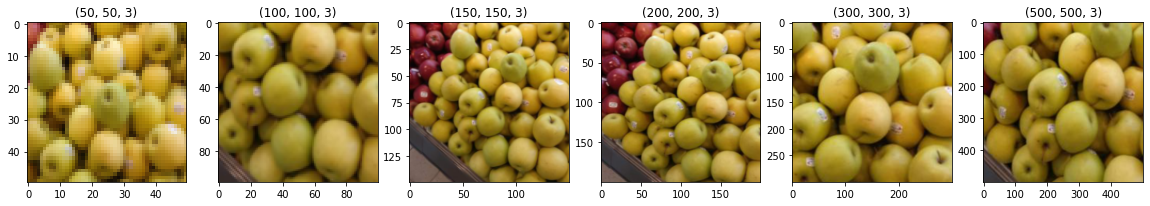

In [20]:
print("Image original size: ", np.array(image).shape)
fig, ax = plt.subplots(1, 6, figsize=(20, 4))
for i, size in enumerate([50, 100, 150, 200, 300, 500]):
  
    transformation = transf.RandomResizedCrop(size)

    crp_img = transformation.forward(image)
    ax[i].imshow(np.array(crp_img))
    ax[i].set_title(np.array(crp_img).shape)

## Random Horizontal Flip

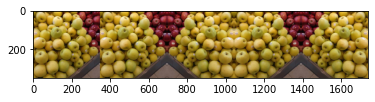

In [21]:
transformation = transf.RandomHorizontalFlip()

maybe_flipped = [transformation.forward(image) for _ in range(5)]

plt.imshow(np.hstack([np.array(img) for img in maybe_flipped]))

## Normalization

The same way we normalize columns for tabular data, here we normalize each image according to the mean and standard deviation of each colour channel.

In [22]:
two_images = [load_image_data(row["image_data"]) for _, row in df_images.iloc[:2].iterrows()]

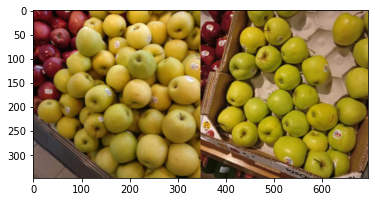

In [23]:
two_image_dataset = np.array([np.array(img) for img in two_images])
two_image_dataset.shape

plt.imshow(np.hstack([np.array(img) for img in two_images]))

In [24]:
np.mean(two_image_dataset, axis=(0, 1, 2))

array([141.43225244, 114.20715253,  44.6037827 ])

In [25]:
transformation = transf.Compose([
        transf.ToTensor(),
        transf.Normalize(
            np.mean(two_image_dataset, axis=(0, 1, 2)),
            np.std(two_image_dataset, axis=(0, 1, 2)),
            )
    ])

In [26]:
transformed_two_image_dataset = [transformation(img) for img in two_image_dataset]

In [27]:
transformed_two_image_dataset

[tensor([[[-2.7336, -2.7329, -2.7332,  ..., -2.7313, -2.7313, -2.7313],
          [-2.7334, -2.7335, -2.7337,  ..., -2.7313, -2.7314, -2.7315],
          [-2.7330, -2.7338, -2.7341,  ..., -2.7315, -2.7316, -2.7316],
          ...,
          [-2.7363, -2.7363, -2.7365,  ..., -2.7326, -2.7325, -2.7324],
          [-2.7363, -2.7363, -2.7364,  ..., -2.7328, -2.7326, -2.7325],
          [-2.7363, -2.7364, -2.7364,  ..., -2.7329, -2.7329, -2.7326]],
 
         [[-2.1374, -2.1366, -2.1365,  ..., -2.1280, -2.1281, -2.1281],
          [-2.1372, -2.1371, -2.1371,  ..., -2.1281, -2.1282, -2.1282],
          [-2.1368, -2.1374, -2.1374,  ..., -2.1282, -2.1283, -2.1284],
          ...,
          [-2.1321, -2.1321, -2.1324,  ..., -2.1296, -2.1296, -2.1294],
          [-2.1321, -2.1321, -2.1322,  ..., -2.1297, -2.1296, -2.1296],
          [-2.1321, -2.1322, -2.1323,  ..., -2.1299, -2.1298, -2.1297]],
 
         [[-1.0863, -1.0853, -1.0853,  ..., -1.0862, -1.0863, -1.0863],
          [-1.0860, -1.0860,

# Using ImageNet

Since training a large neural network requires lots of data and computing power, often we download a pre-trained neural network, which we can later fine-tune.

Here, we will download an ImageNet network.

Remember that since the network is already trained with a specific dataset, when evaluating new images, we need transform them using the same transformations used for training. In particular, that includes using the same normalizations.

In [28]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [29]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We load a maping from resnet integer labels to the actual categories

In [52]:
def predict_using_resnet(image):
    image_preproc = transformation (image)
    batch_image = torch.unsqueeze(image_preproc,0)
    salida = resnet(batch_image)
    _, preds  = torch.max(salida, dim=1)
    return df_images.iloc[0]["coarse_cat"]

#df_images.iloc[0]["coarse_cat"]

    #salida_np = salida.detach().numpy()
    #predict = np.argmax(salida_np) 
    #return predict
    
    
    
    #resnet_prediction=resnet(image)                       #Line 4
    #resnet_prediction_numpy=resnet_prediction.detach().numpy()   #Line 5
    #predicted_class_max = np.argmax(resnet_prediction_numpy)     #Line 6
    #return predicted_class_max 
    
    #image_preproc = transformation(image)
    #batch_image = torch.unsqueeze(image_preproc, 0)
    #salida = resnet(batch_image)
    #index = torch.max(salida, 1)
    #labels = df_images['coarse_cat']
    #percentage = torch.nn.functional.softmax(salida, dim=1)[0] * 100
    #return labels[index[0]], percentage[index[0]].item()

    
    #image_preproc= transformation(image)
    #batch_img = torch.unsqueeze(image_preproc, 0)

    
    
    #prediction = resnet(torch.from_numpy(image))
    #label = decode_predictions(prediction) 
    #return label
    
    
    #image_preproc = transformation (image)
    #batch_image = torch.unsqueeze(image_preproc,0)
    #salida = resnet(batch_image)
    #return salida






In [ ]:

    """
    This image uses the resnet as is to
    predict an image.
    Remember to apply the correct transformations
    to the image before feeding it to the network.
    
    The following link might be useful: https://pytorch.org/hub/pytorch_vision_resnet/
    """
    
    # Write your code here

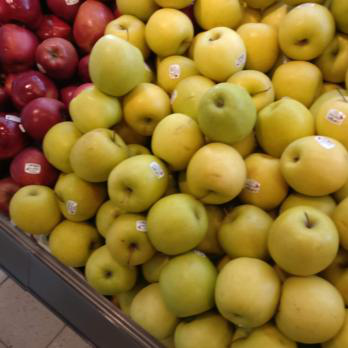

In [46]:
img1 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Apple"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img1

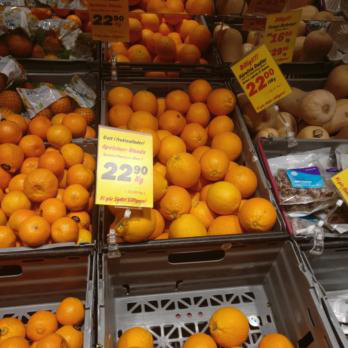

In [47]:
img2 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Orange"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img2

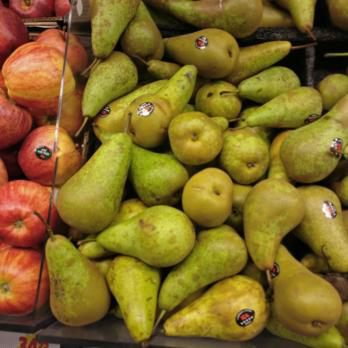

In [48]:
img3 = (
    load_image_data(
        df_images[
            df_images["coarse_cat"] == "Pear"
        ]
        .iloc[0]
        ["image_data"]
    )

)
img3

In [53]:
pred1 = predict_using_resnet(img1)
pred1

'Apple'

In [54]:
assert pred1 == "lemon"

AssertionError: ignored

In [55]:
pred2 = predict_using_resnet(img2)
print(pred2)

Apple


In [56]:
pred3 = predict_using_resnet(img3)
print(pred3)

Apple


In [57]:
proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': 
[
         {
            "name": "center_crop",
            "answer": np.array_str(answer_center_crop),
         },

         {
            "name": "resnet_pred2",
            "answer": pred2,
         },
         {
            "name": "resnet_pred3",
            "answer": pred3,
         }
]

}
check_solution(proposed_solution)
    

|                    Task Name                     |       Status       |
|--------------------------------------------------|--------------------|
|--------------------------------------------------|--------------------|
|                   center_crop                    |      Correct       |
|--------------------------------------------------|--------------------|
|                   resnet_pred2                   |     Incorrect      |
|--------------------------------------------------|--------------------|
|                   resnet_pred3                   |     Incorrect      |
|--------------------------------------------------|--------------------|
